In [1]:
from qiskit.circuit.random import random_circuit 
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_cutting.automated_cut_finding import (find_cuts, OptimizationParameters, DeviceConstraints,)
from qiskit_addon_cutting import cut_wires, expand_observables, partition_problem, generate_cutting_experiments, reconstruct_expectation_values
import numpy as np
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2, Batch 
from qiskit_aer.primitives import EstimatorV2

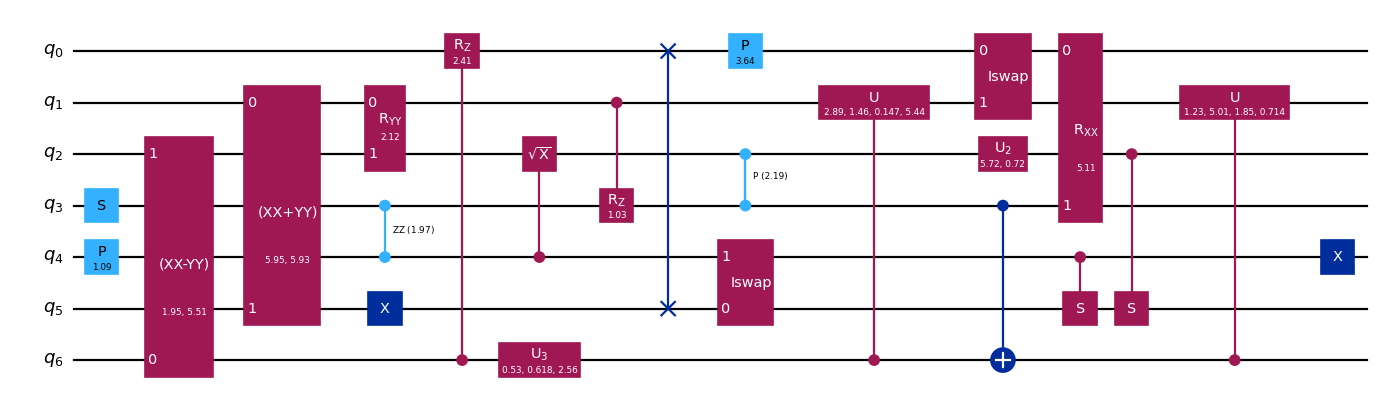

In [2]:
# Map

circuit = random_circuit(7, 6, max_operands=2, seed=1242)
observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])


circuit.draw("mpl", scale=0.8)

Found solution using 8 cuts with a sampling overhead of 59776343.19975524.
Lowest cost solution found: False.
Gate Cut at circuit instruction index 6
Gate Cut at circuit instruction index 8
Gate Cut at circuit instruction index 9
Wire Cut at circuit instruction index 10
Gate Cut at circuit instruction index 15
Gate Cut at circuit instruction index 18
Gate Cut at circuit instruction index 19
Gate Cut at circuit instruction index 21


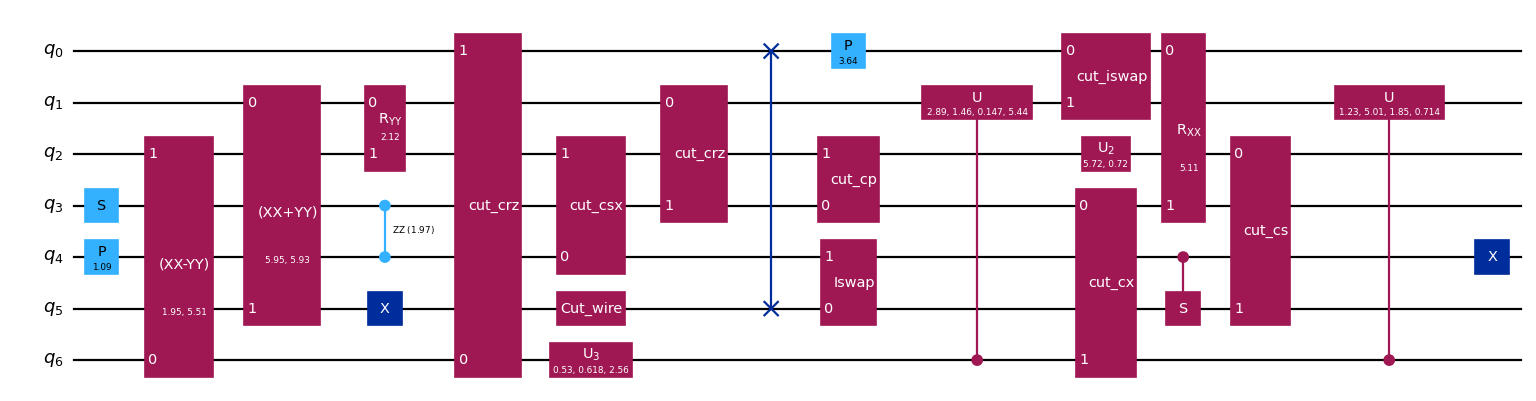

In [3]:
# Optimize, with 4 qubits per subcircuit maximum 

# Specifying settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specifying the size of the QPUs available 
device_constraints = DeviceConstraints(qubits_per_subcircuit=4)

cut_circuit, metadata = find_cuts(circuit, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

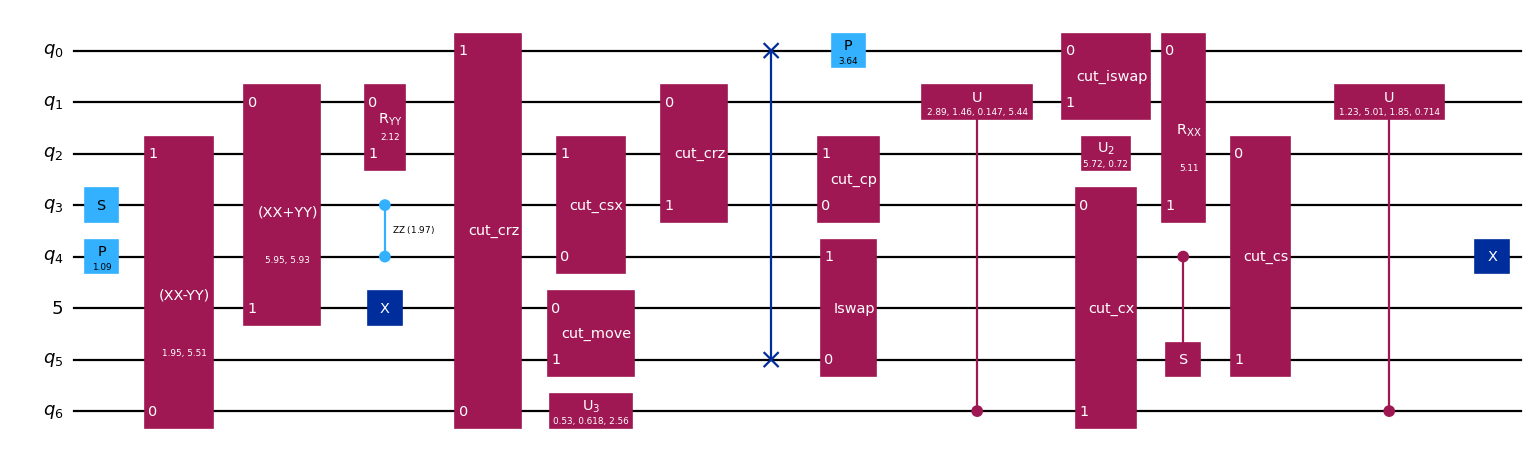

In [4]:
# Adding ancillas for wire cuts and expanding observables 
qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, circuit, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [5]:
# Partitioning the map into circuit and observables
partitioned_problem = partition_problem(circuit=qc_w_ancilla, observables=observables_expanded)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}")

Sampling overhead: 59776343.19975523


In [6]:
subobservables 

{0: PauliList(['IIII', 'IIZI', 'IIIZ']),
 1: PauliList(['ZIII', 'IIII', 'IIII'])}

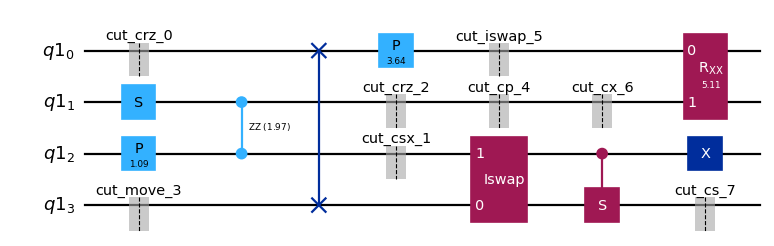

In [7]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8)

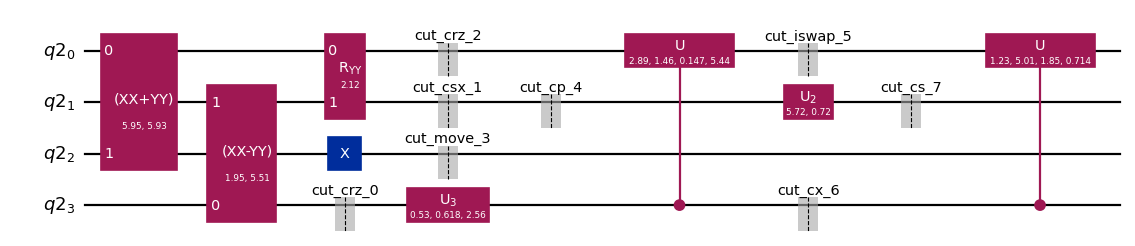

In [8]:
subcircuits[1].draw("mpl", style="iqp", scale=0.8)

In [9]:
# Generating subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(circuits=subcircuits, observables=subobservables, num_samples=1_000)
print(f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend.")

# Choosing a backend 
backend = FakeManilaV2()

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {label: pass_manager.run(partition_subexpts) for label, partition_subexpts in subexperiments.items()}

# Submit each partition's subexperiments to the Qiskit Runtime Sampler primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {label: sampler.run(subsystem_subexpts, shots=2**12) for label, subsystem_subexpts in isa_subexperiments.items()}

# Results 
results = {label: job.result() for label, job in jobs.items()}

2000 total subexperiments to run on backend.
